# Integrantes

## - Reichel Larez. Número de estudiante: 344474
## - Natalia Campiglia: Número de estudiante: 349251

# Reinforcement Learning Tarea 3 - Métodos Monte Carlo (blackjack)

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en [Gymnasium](https://gymnasium.farama.org/index.html), es el caso esta vez de otro ambiente sencillo: el juego de Blackjack. El [ambiente de gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por lo que no es necesario crearlo desde cero. 


## Descripción del ambiente a usar

### Reglas del juego

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable" y es su valor por defecto.
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador se queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

### Implementación en Gymnasium

- La reward por perder es -1, por ganar es +1 y por pedir carta es 0. En caso de empate, la reward es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

Revisa el [ambiente en gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) para entender como funciona.


### A entregar

- Notebook con solución a los algoritmos presentados
- Analisis de la función de valor estimada para distinto número de episodios a visitar (ej: 100, 10000, 50000, 500000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de función de valor para otras politicas definidas por el estudiante (al menos una). 

In [66]:
import gymnasium as gym
from gymnasium.utils.play import play
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from Utils import plot_value_distribution, plot_Q_distribution

In [67]:
# Nos asegurams que las gráficas se muestren en el notebook
import matplotlib
%matplotlib inline

 Vemos el espacio de estado y acción del ambiente de blackjack.

In [68]:
# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1", render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [69]:
# vemos un ejemplo de observación
obs, _ = env.reset()
print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")

Jugador: 16, Dealer: 1, As usable: 0 


Simulemos una partida de blackjack.

In [70]:
# Caso de prueba
state,_ = env.reset()
print('initial state:', state)

while True:
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    print('state:', state, 'reward:', reward, 'done:', done)
    if done or truncated:
        print(f'Reward: {reward}')                
        break

initial state: (12, 10, 0)
state: (22, 10, 0) reward: -1.0 done: True
Reward: -1.0


## Predicción de la función de valor ($V$ y $Q$)

Vamos a implementar el algoritmo de Monte Carlo para estimar las funciones de valor $V$ y $Q$ para el ambiente de blackjack asi como algunas variantes (first visit, every visit, exploración inicial, etc).

Para ello primero vamos a definir una politica: Si suma 20 o más, se queda (STICK), si no pide carta (HIT). Esta política es la que se usa en el ejemplo del libro.

In [71]:
STICK = 0
HIT = 1
       
## Politica Sutton & Barto
def sutton_policy(observation):
    sum, _, _ = observation
    return STICK if sum >= 20 else HIT

### Generación de episodios

Vamos a implementar una función que genere episodios de la política definida. La función va a recibir el ambiente y la política y va a devolver una lista de transiciones (estado, acción, reward, next_state).

In [72]:
def generate_episode(policy, env):
    """
    Genera un episodio utilizando la política dada.
    Args:
        policy: Función que toma un estado y devuelve una acción.
        env: Entorno de OpenAI Gym.
    Returns:
        episode: Lista de tuplas (estado, acción, recompensa, siguiente_estado).
    """
    episodio = []
    state, _ = env.reset()
    done = False
    while not done:
        action = policy(state)
        new_state, reward, terminated, truncated, _=  env.step(action)
        episodio.append((state, action, reward, new_state))
        done = terminated or truncated
        state = new_state
    
    return episodio


In [73]:
# lo probamos
episode = generate_episode(sutton_policy, env)
print("Episodio generado:")
for state, action, reward, next_state in episode:
    print(f"Estado: {state}, Acción: {action} ({'Hit' if action == 1 else 'Stick'}), Recompensa: {reward}, Siguiente estado: {next_state}")

Episodio generado:
Estado: (15, 5, 0), Acción: 1 (Hit), Recompensa: -1.0, Siguiente estado: (25, 5, 0)


### First-Visit MC para estimar $V$

El primer algoritmo que vamos a implementar es el de Monte Carlo First Visit. Este algoritmo estima la función de valor $V$ para una política dada.

$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }v_\pi\text{):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{política a evaluar.}\\
& \quad \text{(Se asume que podemos generar episodios con } \pi\text{.)}\\[6pt]
\textbf{Inicializar:} 
& \quad V(s) \in \mathbb{R}, \quad \forall\, s \in S \quad (\text{valores arbitrarios})\\
& \quad \text{Returns}(s) \leftarrow \varnothing, \quad \forall\, s \in S.\\[6pt]
\textbf{Bucle (por cada episodio):} 
& \\[-2pt]
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\, T-2,\, \ldots,\, 0:\\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } S_t \notin \{S_0, S_1, \ldots, S_{t-1}\}:\\
& \quad\quad\quad \text{Returns}(S_t) \leftarrow \text{Returns}(S_t) \cup \{G\}.\\
& \quad\quad\quad V(S_t) \leftarrow \text{average}\bigl(\text{Returns}(S_t)\bigr).\\[6pt]
\textbf{Retornar:} 
& \quad V.
\end{aligned}
$$

> Tip: con [defaultdict](https://docs.python.org/3/library/collections.html#defaultdict-objects) podemos definir un diccionario con un valor por defecto.

In [74]:
A = defaultdict(float)
B = defaultdict(int)
C = defaultdict(lambda: [])

In [75]:
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1.0):
    V = defaultdict(float)
    Retornos = defaultdict(lambda: [])
    for i in tqdm(range(number_episodes)):
        episode = generate_episode(policy, env)
        G = 0
        T = len(episode)
        t = T - 1
        
        while t >= 0:
            state, _, reward, _ = episode[t]
            G = gamma*G + reward
            states_hasta_t = [s for s, _, _, _ in episode[:t]]
            if state not in states_hasta_t:
                # first visit
                Retornos[state].append(G)
                V[state] = np.mean(Retornos[state])
            t -=1
    return V
            

In [76]:
sab_value = first_visit_mc_prediction(sutton_policy, env, number_episodes=50_000)

100%|██████████| 50000/50000 [00:03<00:00, 13713.51it/s]


In [77]:
#print(sab_value)

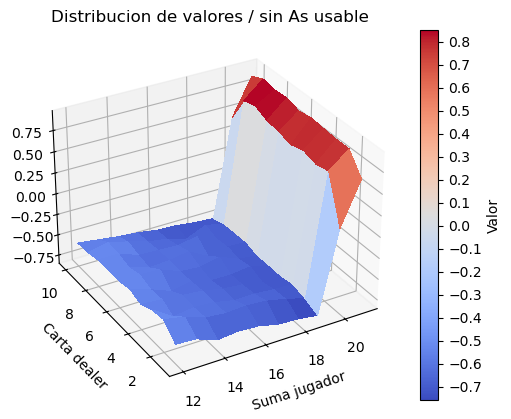

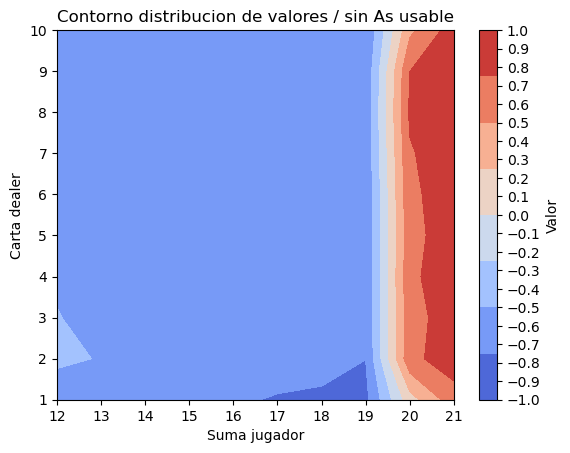

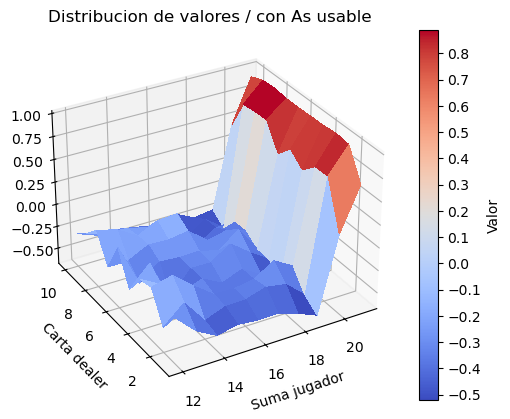

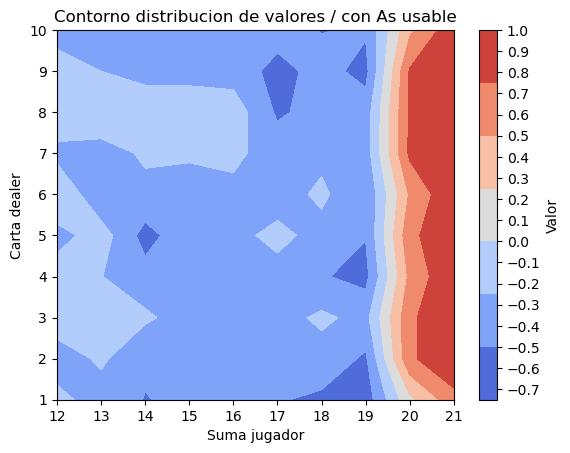

In [78]:
plot_value_distribution(sab_value)

<div style=" border-left: 6px solid #28a745; padding: 10px; border-radius: 5px;">

 # Comentarios

### Sin As usable: 
Los graficos nos muestran que ante una **Suma de jugador** menor a 14, el valor de V es negativo lo que indica alta probabilidad de perder. Por otro lado a medida esta suma aumenta el valor esperado pasa a ser positivo, donde **sumas de jugador** entre los 19 y los 21 las que dan mayores probabilidades de ganar. Los graficos no muestra picos, mostrando un comportamiento consistente de la politica.

 
### Con As usable
Podemos ver que para este caso aparecen picos, lo que indica que hay mas variabilidad. Esto se debe a que As usable da más flexibilidad dado que puede valer 1 o 11, y con esto el usuario puede evitar pasarse en la suma.
Al igual que para el caso de **Sin As usable** se sigue manteniendo el hecho de que mayores sumas dan mejores resultados, seria el caso de sumas de 19, 20 0 21. Parece ser que Con AS usable se obtinen mejores resultados pero se agrega mas incertidumbre dado que la jugada depende de como se usa el **As**

 

</div>

# Comparación de estimaciones de la función de valor según número de episodios


100%|██████████| 100/100 [00:00<00:00, 5771.95it/s]


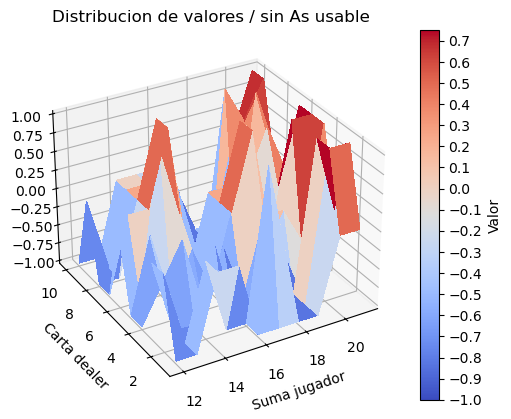

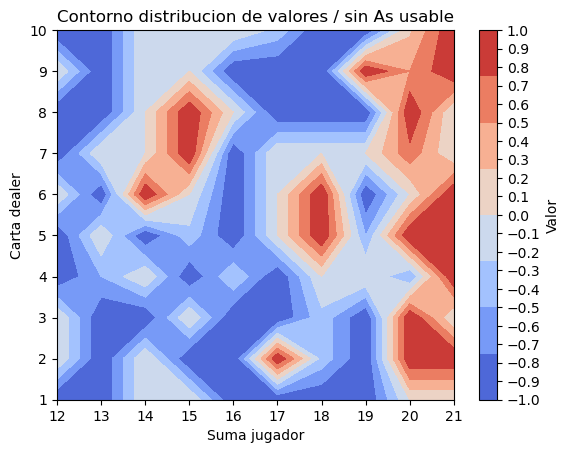

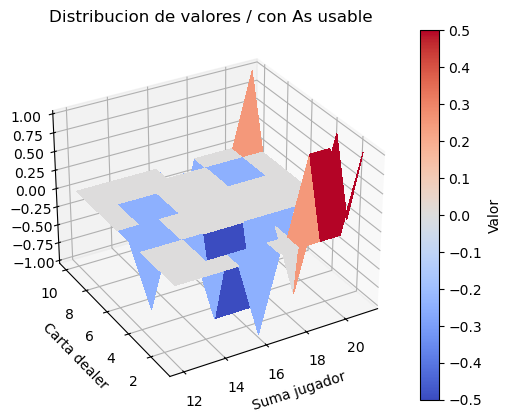

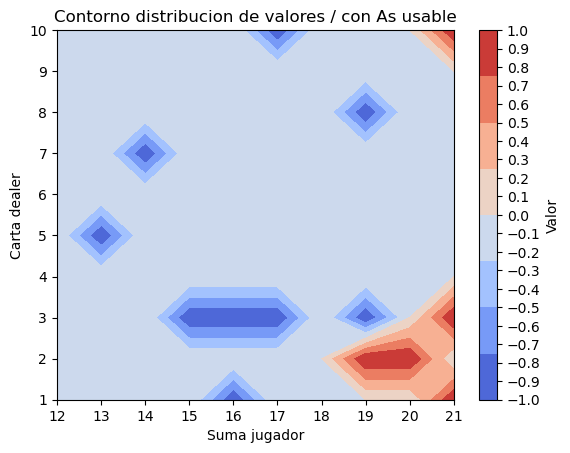

In [79]:
#100, 10000, 50000, 500000
sab_value_100 = first_visit_mc_prediction(sutton_policy, env, number_episodes=100)
plot_value_distribution(sab_value_100)

100%|██████████| 10000/10000 [00:00<00:00, 16134.63it/s]


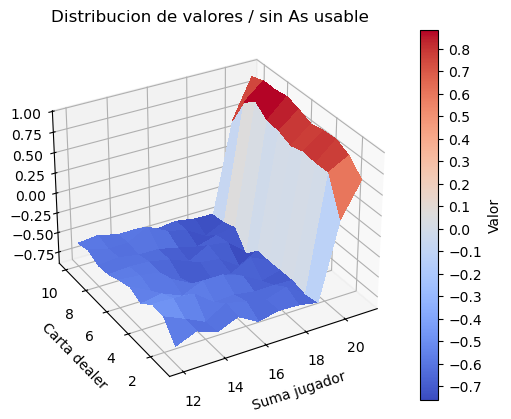

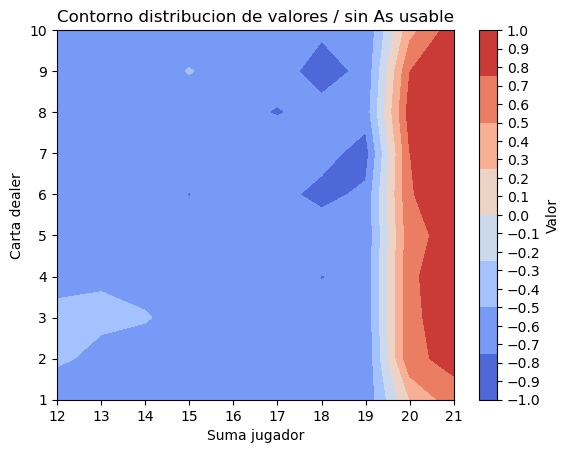

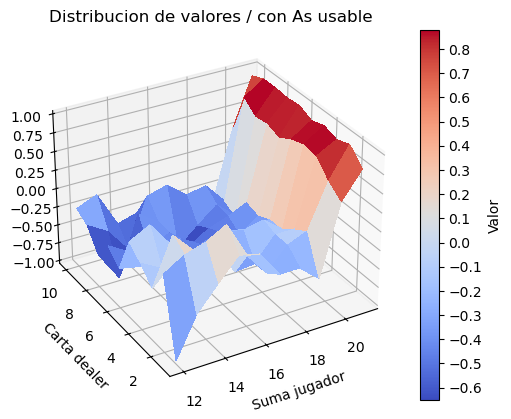

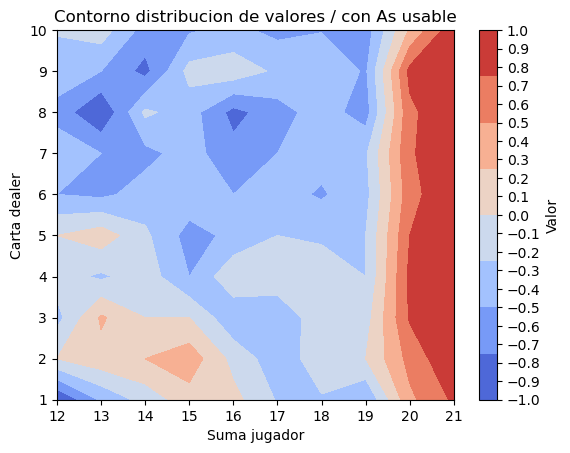

In [80]:
sab_value_10000 = first_visit_mc_prediction(sutton_policy, env, number_episodes=10000)
plot_value_distribution(sab_value_10000)

100%|██████████| 50000/50000 [00:03<00:00, 13753.86it/s]


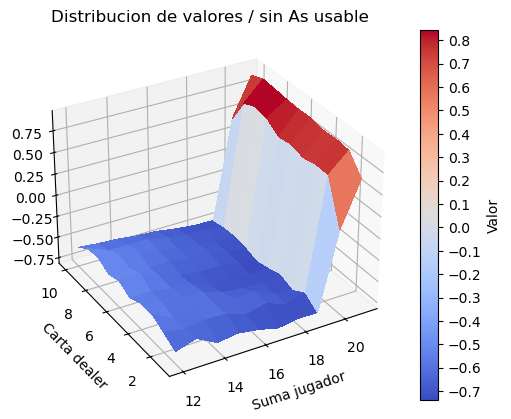

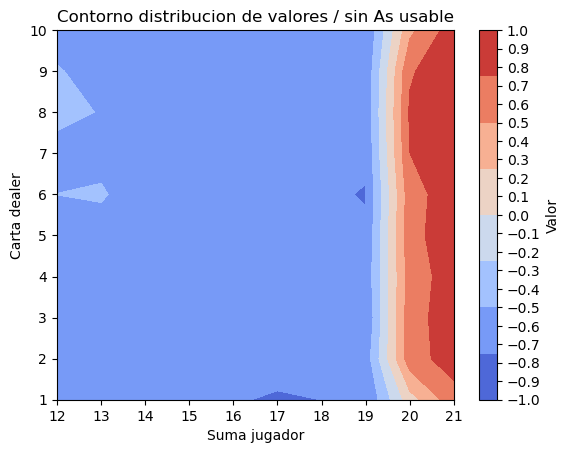

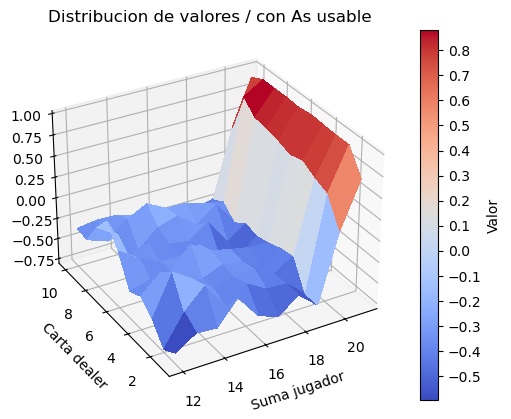

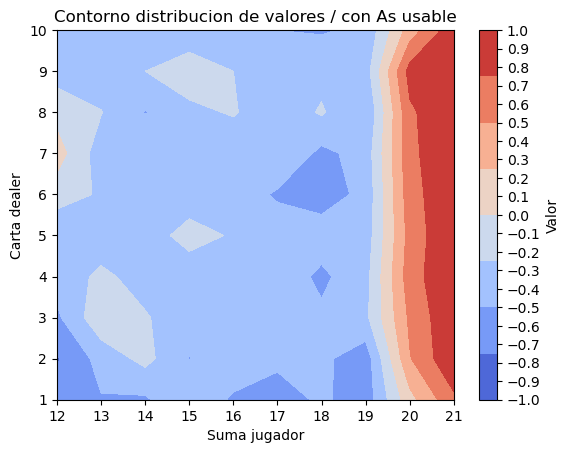

In [81]:
sab_value_50_000 = first_visit_mc_prediction(sutton_policy, env, number_episodes=50_000)
plot_value_distribution(sab_value_50_000)

100%|██████████| 500000/500000 [02:40<00:00, 3118.99it/s]


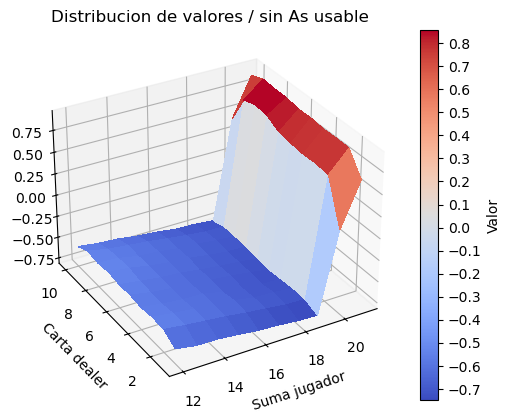

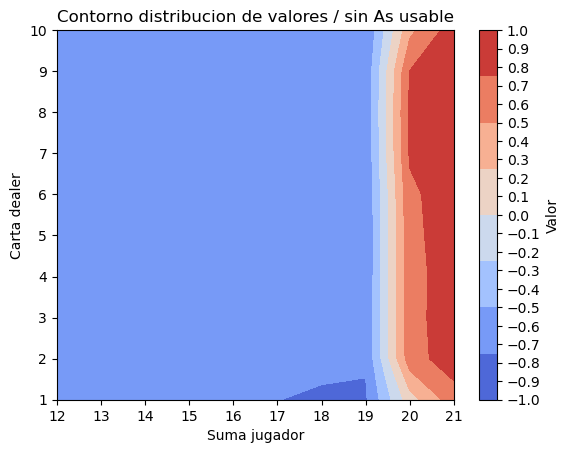

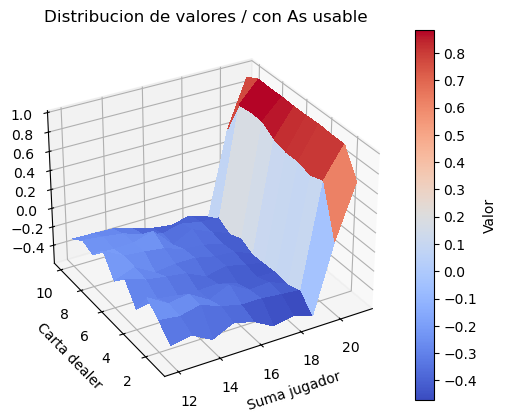

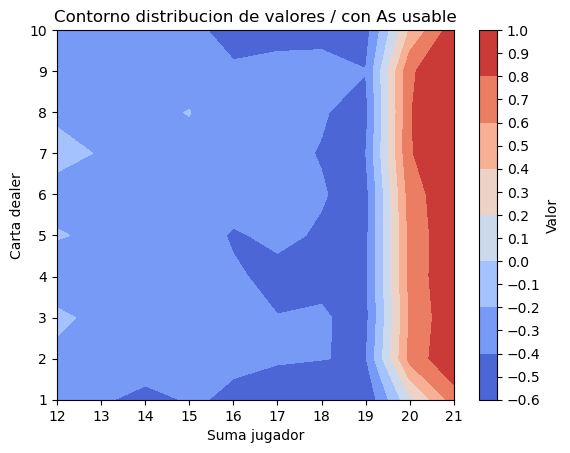

In [82]:
sab_value_500_000 = first_visit_mc_prediction(sutton_policy, env, number_episodes=500_000)
plot_value_distribution(sab_value_500_000)

# Comparación de estimaciones de la función de valor según número de episodios

A continuación se comparan los resultados de la estimación de la función de valor utilizando el algoritmo **First-Visit Monte Carlo Prediction**, variando el número de episodios: 100, 10 000, 50 000 y 500 000.

---

## Evolución de las estimaciones

| Número de episodios | Observaciones principales |
|:--------------------|:---------------------------|
| **100** | Estimaciones muy ruidosas. Muchas zonas planas, sin patrones claros y con mucho ruido en ambas superficies (con y sin As usable). |
| **10 000** | Comienza a aparecer la forma general de la función de valor. Se ve que valores más altos (rojos) se concentran donde el jugador tiene suma alta (19-21). Aún hay bastante ruido, sobre todo con As usable. |
| **50 000** | Estimaciones mucho más suaves. La estructura esperada de la función de valor es clara: valores bajos con sumas pequeñas y altos cerca de 20-21. El ruido se reduce, aunque persiste algo para estados menos frecuentes. |
| **500 000** | Estimaciones muy estables. Se pueden ver valores altos donde el jugador tiene ventaja, y valores bajos donde arriesga más. Tanto con como sin As usable la superficie tiene muy poco ruido. |

---

## Conclusiones principales

- A medida que aumentamos el número de episodios, **se reduce el ruido** y **las estimaciones convergen** hacia la verdadera función de valor.
- **Con pocos episodios**, los estados poco visitados (por ejemplo, valores intermedios o escenarios específicos de As usable) tienen valores inestables o erróneos.
- **Con más episodios**, la función de valor refleja cada vez mejor el comportamiento esperado: es mejor tener sumas altas (~20) y peor tener sumas bajas (~12-14).
- El impacto de tener un **As usable** también se refleja mejor a medida que aumentan los episodios: los valores son un poco más optimistas en ese caso.

---


Una estrategía más elaborada, basada en Edward Thorp, que se basa en la carta del dealer y la suma del jugador. La idea es que si el dealer tiene una carta baja (2-6) el jugador se queda si tiene 12 o más, si no pide carta. Si el dealer tiene una carta alta (7-10) el jugador se queda si tiene 17 o más, si no pide carta.

100%|██████████| 50000/50000 [00:03<00:00, 15360.82it/s]


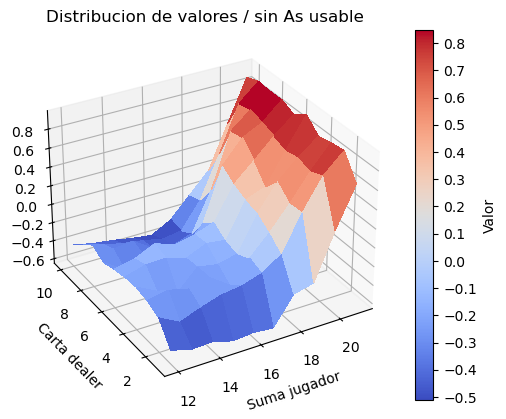

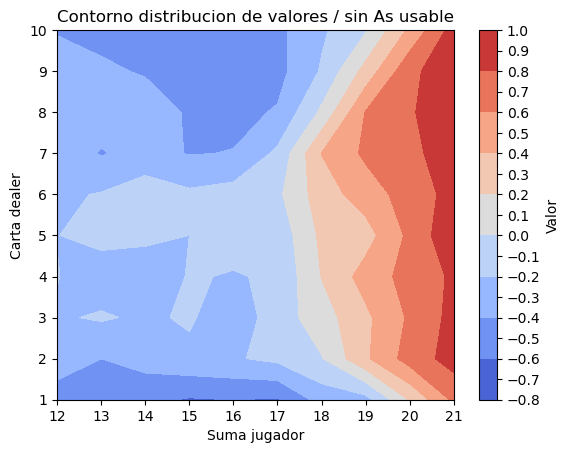

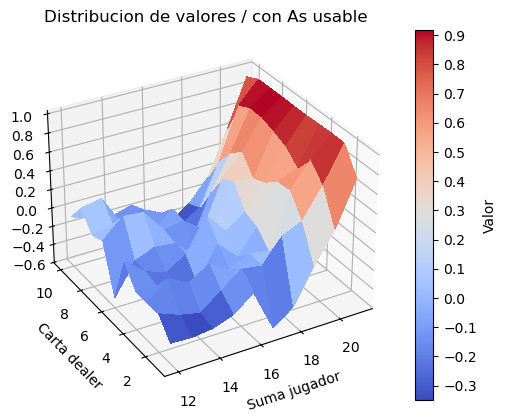

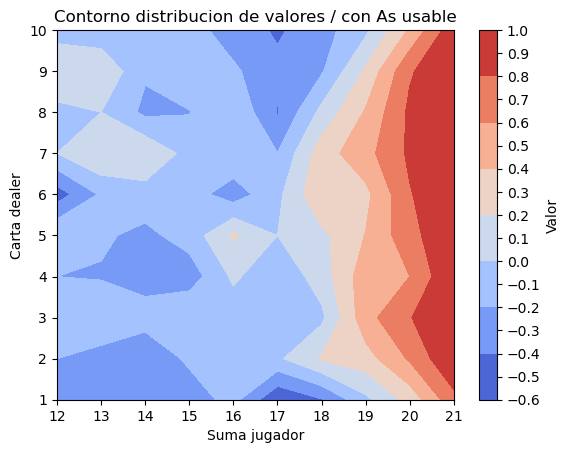

In [83]:
def thorp_policy(observation):
    player_sum, dealer_card, usable_ace = observation
    # Si la suma del jugador es menor a 12, nunca se pasa, así que se pide carta.
    if player_sum < 12:
        return HIT
    # Para sumas entre 12 y 16, se aconseja quedarse si el dealer muestra una carta débil (2 a 6),
    # ya que el dealer tiene más probabilidad de pasarse.
    if 12 <= player_sum <= 16:
        if 2 <= dealer_card <= 6:
            return STICK
        else:
            return HIT
    # Con una suma de 17 o mayor, es recomendable plantarse.
    return STICK

thorp_value = first_visit_mc_prediction(thorp_policy, env, number_episodes=50_000)

plot_value_distribution(thorp_value)

> 1) ¿Qué valores se esperan de $V$ si implementamos el algoritmo de Monte Carlo Every Visit en este caso? ¿Por qué?
> 2) Definir una política diferente que tenga en cuenta el As usable y estimar su función de valor. 

<div style=" border-left: 6px solid #28a745; padding: 10px; border-radius: 5px;">

 # Respuestas

> 1) ¿Qué valores se esperan de $V$ si implementamos el algoritmo de Monte Carlo Every Visit en este caso? ¿Por qué?

Los valores de $V$ esperados para MC every visit son los mismos que de firts visit, porque es imposible que un episodio se visite el mismo estado, entonces el comportamiento del every visit es igual al del first visit.

 

</div>

In [84]:
def policy_with_usable_ace(observation):
    sum_jugador, carta_dealer, usable_ace = observation
    if usable_ace:
        return STICK if sum_jugador >= 18 else HIT
    else:
        return STICK if sum_jugador >= 20 else HIT

100%|██████████| 50000/50000 [00:03<00:00, 14137.89it/s]


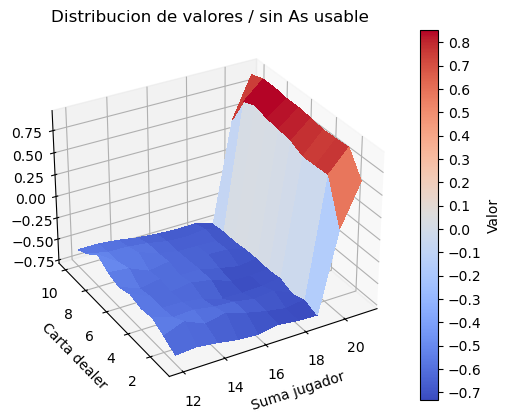

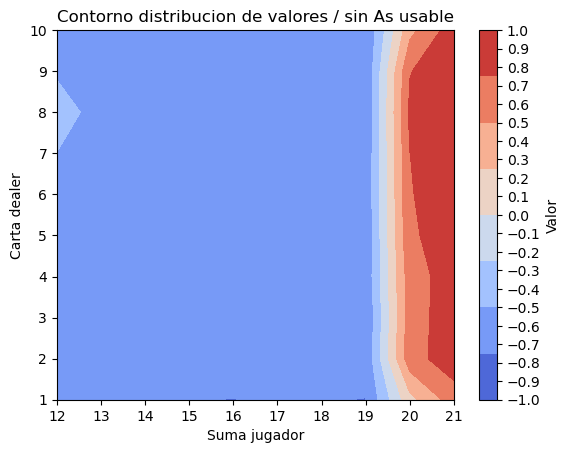

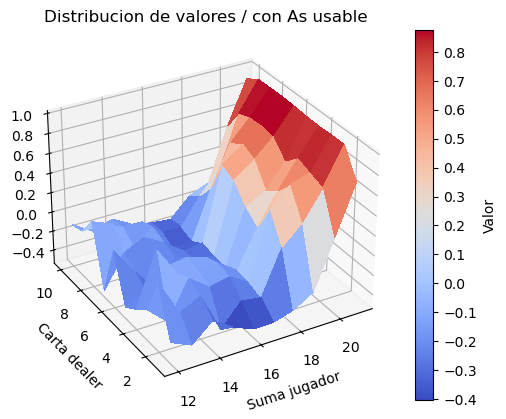

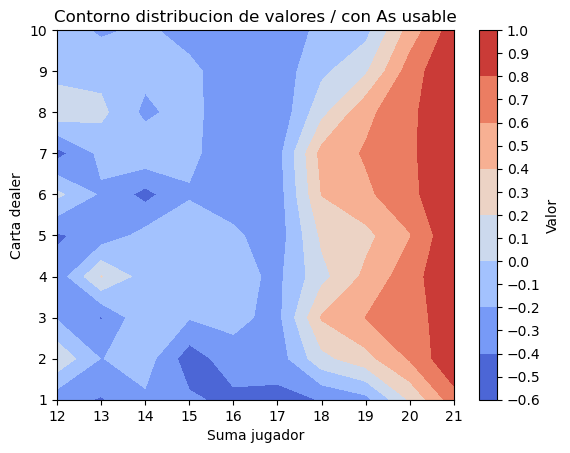

In [85]:
with_ace_value = first_visit_mc_prediction(policy_with_usable_ace, env, number_episodes=50_000)

plot_value_distribution(with_ace_value)

### First-Visit MC para estimar $Q$ con exploración inicial

Cuando queremos estimar la función de valor $Q$ para una política dada, tenemos el problema de que no tenemos una política exploratoria. Por ende podría no visitar todos los estados y acciones. Para resolver esto, podemos usar la técnica de exploración inicial donde se elige un estado aleatorio ($S_0$) y una acción aleatoria ($A_0$) y se juega un episodio desde ahí. Esto nos permite explorar el espacio de estados y acciones. 

> Notar que la política no cambia, solo se elige un estado y acción aleatorios para empezar a jugar.

> El desafío en Gymnasium es que no podemos elegir el estado inicial. Pero podemos intentar "hacer trampa" y modificar su estado interno. Esto no es recomendable, pero para fines de este laboratorio lo vamos a hacer.


$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }Q(s,a)\text{ con exploración inicial):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{la política a evaluar.}\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a) \in \mathbb{R}\quad \text{(valores arbitrarios)},\quad \forall\, s \in S,\; a \in A(s),\\
& \quad \text{Returns}(s,a) \leftarrow \varnothing,\quad \forall\, s \in S,\; a \in A(s).\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Elegir al azar un estado inicial } S_0 \in S \text{ y una acción } A_0 \in A(S_0).\\
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, S_1, A_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\; T-2,\; \ldots,\; 0: \\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } (S_t,A_t) \notin \{(S_0,A_0),\,(S_1,A_1),\,\ldots,\,(S_{t-1},A_{t-1})\}: \\
& \quad\quad\quad \text{Returns}(S_t,A_t) \leftarrow \text{Returns}(S_t,A_t) \cup \{G\}.\\
& \quad\quad\quad Q(S_t,A_t) \leftarrow \text{average}\Bigl(\text{Returns}(S_t,A_t)\Bigr).\\[6pt]
\textbf{Retornar:} & \quad Q.
\end{aligned}
$$


In [86]:
from gymnasium.envs.toy_text.blackjack import BlackjackEnv

# https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/blackjack.py
# https://gymnasium.farama.org/api/wrappers/#gymnasium.Wrapper
class BlackjackEnvWrapper(BlackjackEnv):
    def set_state(self, state):
        """
        Fija el estado inicial deseado.
        state: (player_sum, dealer_card, usable_ace)
        """
        player_sum, dealer_card, usable = state
        # Configuramos la mano del jugador
        if usable:
            # Para tener un as usable, construimos una mano que contenga un 1 y otra carta que
            # haga que la suma (1 + otra carta + 10) sea player_sum.
            card = player_sum - 11
            # Aseguramos que la otra carta esté en el rango permitido (1 a 10)
            card = max(1, min(card, 10))
            self.player = [1, card]
        else:
            # Sin as usable, buscamos dos cartas que sumen player_sum
            # Esto es una simplificación; se podría mejorar para asegurarse de no incluir un 1.
            card1 = player_sum // 2
            card2 = player_sum - card1
            card1 = max(2, min(card1, 10))
            card2 = max(2, min(card2, 10))
            self.player = [card1, card2]
        
        # Configuramos la mano del dealer de modo que su carta visible sea la deseada.
        self.dealer = [dealer_card, np.random.randint(1, 11)]


In [87]:
def generate_episode_with_initial_exploration(policy, env):
    """
    Genera un episodio utilizando la política dada, con exploración inicial.
    """
    episode = []
    env.reset()
    
    # Escogemos un estado inicial aleatorio
    player_sum = np.random.randint(4, 22)   # suma entre 4 y 21
    dealer_card = np.random.randint(1, 11)     # carta del dealer entre 1 y 10
    usable = np.random.randint(0, 2)           # 0 o 1
    # Elejimos stado al azar 
    state = (player_sum, dealer_card, usable)
    
    # Usamos el método del wrapper para fijar el estado
    env.set_state(state)
    state = env._get_obs()

    done = False
    first_action = True
    while not done:
         # primera accion al azar
        if first_action: 
            action = env.action_space.sample()
            first_action = False
         # proximas acciones basadas en la politica
        else:
            action = policy(state)
        next_state, reward, done, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode



In [88]:
env_wrapped = BlackjackEnvWrapper(env)

In [89]:
generate_episode_with_initial_exploration(thorp_policy, env_wrapped)



[((16, 6, 1), np.int64(0), -1.0)]

In [90]:
generate_episode_with_initial_exploration(sutton_policy, env_wrapped)

[((18, 4, 1), np.int64(0), 1.0)]

In [91]:
def first_visit_mc_q_prediction_ie(policy, env, number_episodes, gamma=1.0):
    """
    First-Visit MC Prediction para estimar Q(s,a) con exploración inicial (Exploring Starts).

    Args:
        policy: política a evaluar (función que recibe un estado y devuelve una acción).
        env: entorno (por ejemplo, Blackjack).
        number_episodes: número de episodios a simular.
        gamma: factor de descuento.

    Returns:
        Q: estimación de la función valor-acción Q(s,a).
    """
    
    # Inicializamos Q y Returns 
    Q = defaultdict(float)
    Returns = defaultdict(list)

    for _ in range(number_episodes):
        episode = generate_episode_with_initial_exploration(policy, env)
        
        G = 0
        visited_state_actions = set()

        for t in reversed(range(len(episode))):
            state_t, action_t, reward_t = episode[t]
            G = gamma * G + reward_t

            if (state_t, action_t) not in visited_state_actions:
                visited_state_actions.add((state_t, action_t))
                Returns[(state_t, action_t)].append(G)
                Q[(state_t, action_t)] = np.mean(Returns[(state_t, action_t)])

    return Q


In [92]:
sab_q_value = first_visit_mc_q_prediction_ie(sutton_policy, env_wrapped, number_episodes=50_000)

In [93]:
sab_q_value[(21, 5, 0), 0]

np.float64(0.8910505836575876)

In [94]:
sab_q_value[(21, 5, 0), 1] # Por que da esto?

0.0

<div style=" border-left: 6px solid #28a745; padding: 10px; border-radius: 5px;">

 # Por que da esto? (sab_q_value[(21, 5, 0), 1] = 0.0)

Dado que estamos usando la politica **sutton_policy** donde siempre que la suma es mayor o igual a 20 la accion a tomar  es **STICK** el estado **[(21, 5, 0), 1]** nunca es actualizado porque tendriamos que tomar la accion **HIT** con suma 21 y es por esto mantiene su valor original 0.0

 

</div>

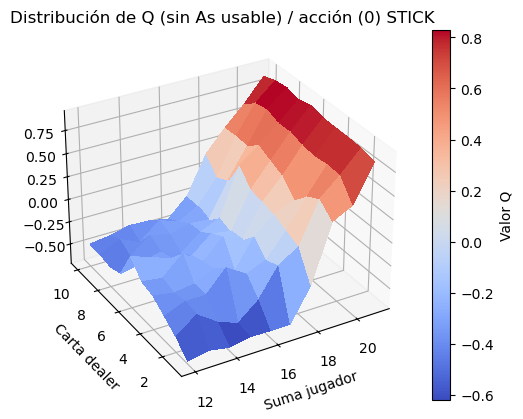

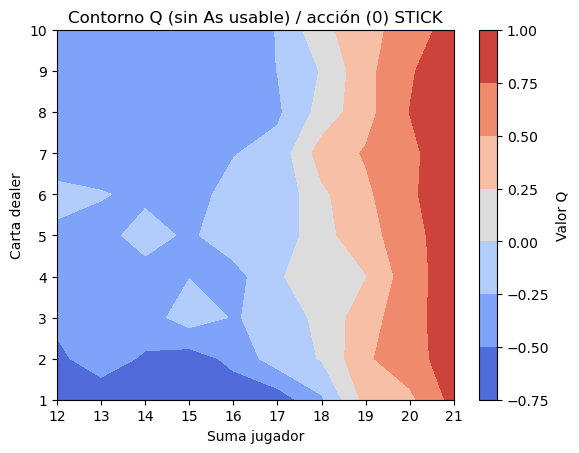

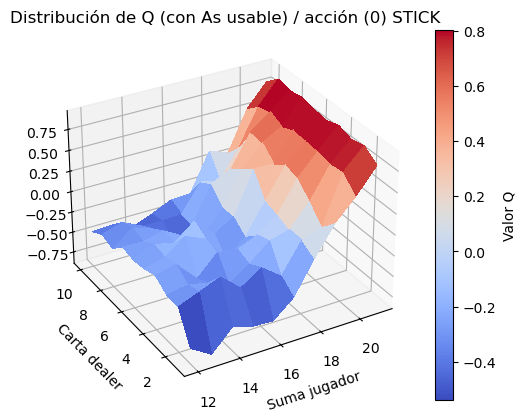

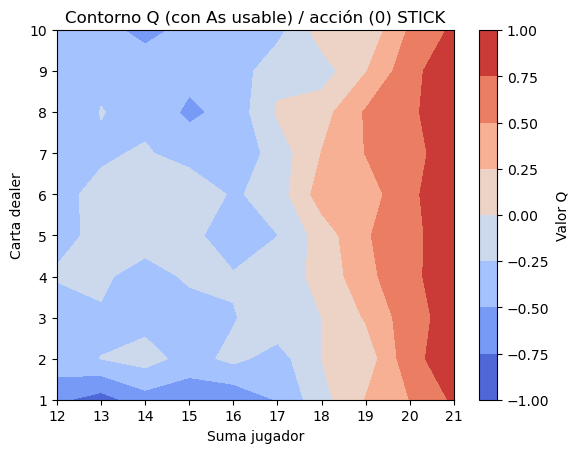

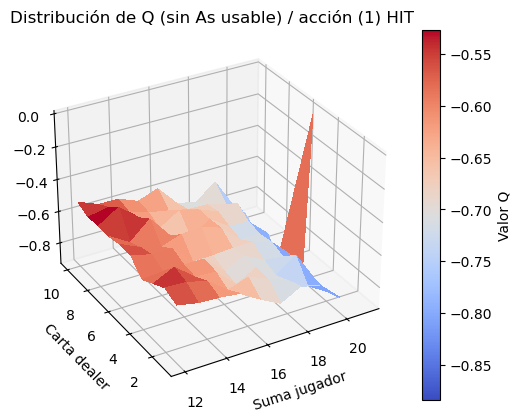

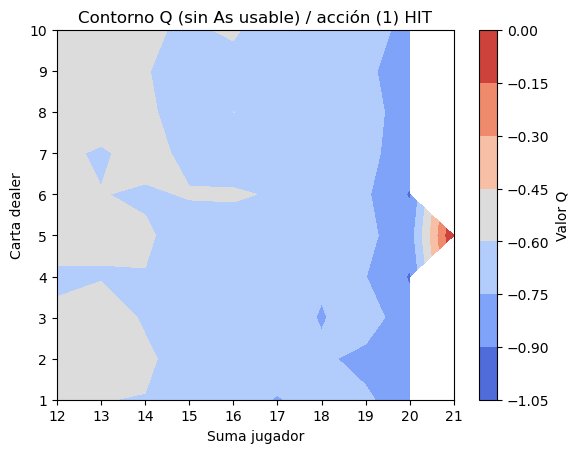

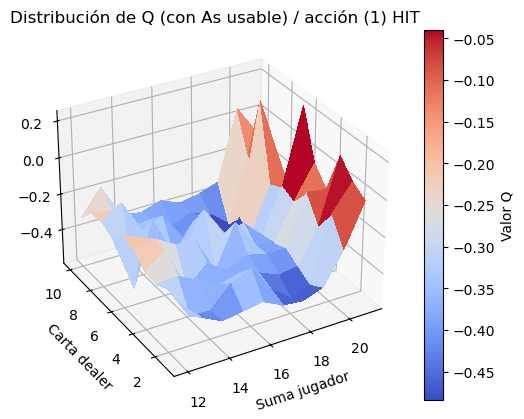

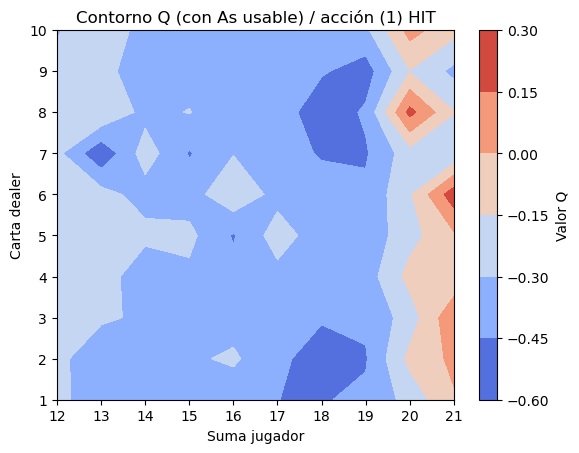

In [95]:
plot_Q_distribution(sab_q_value)

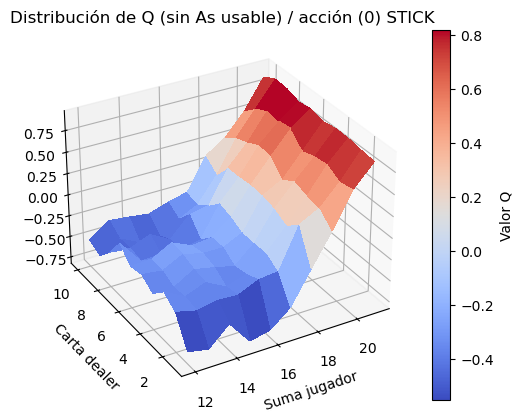

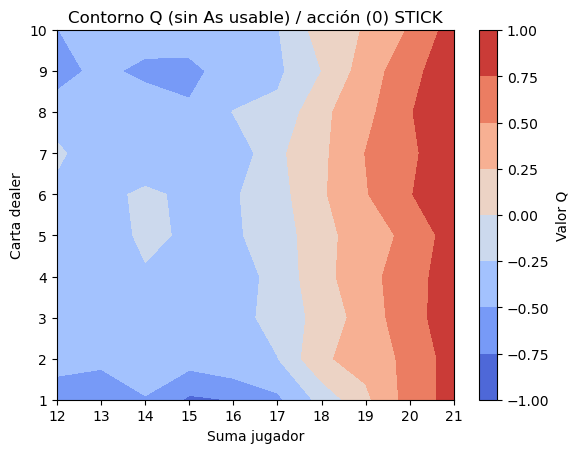

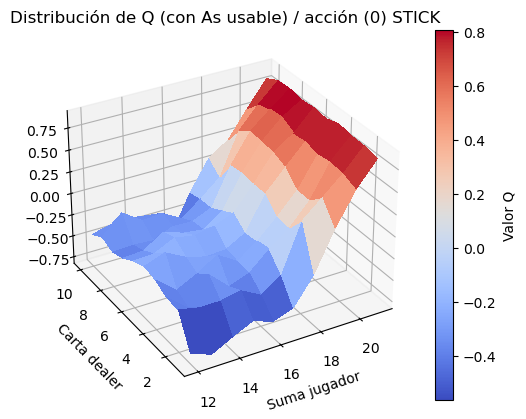

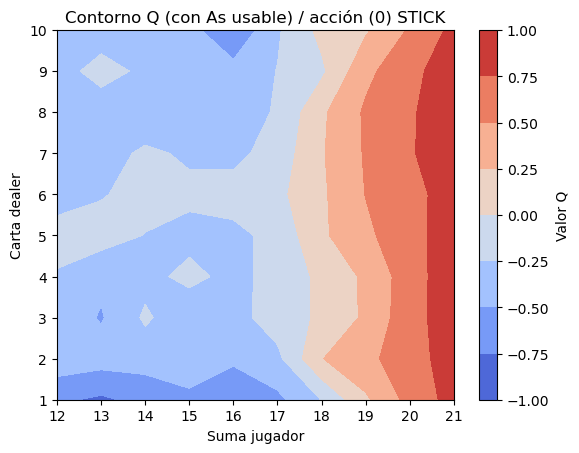

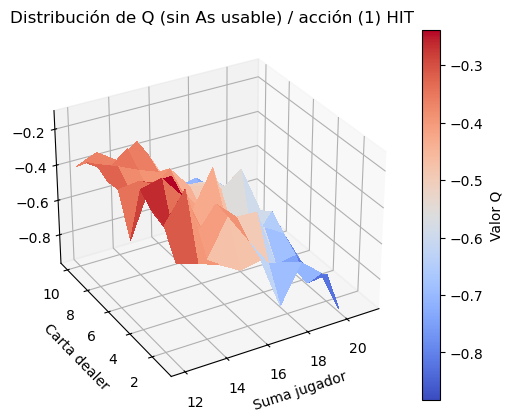

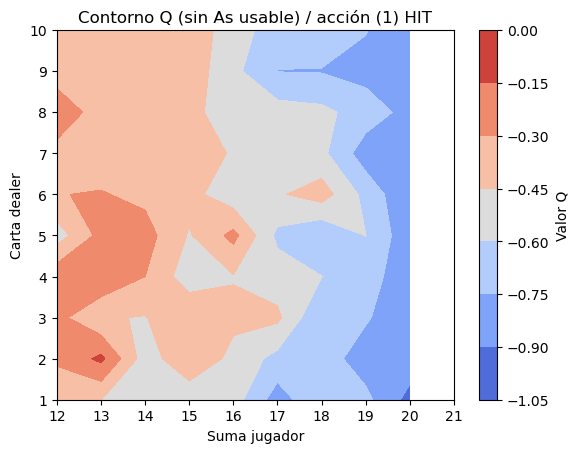

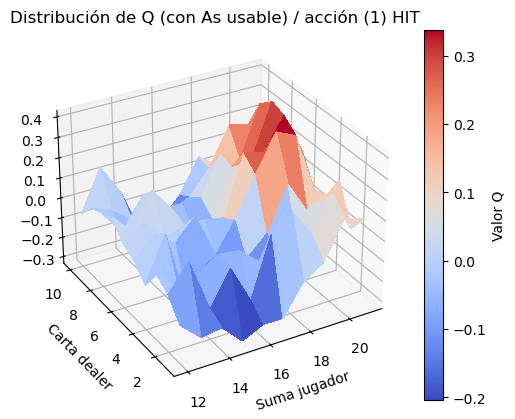

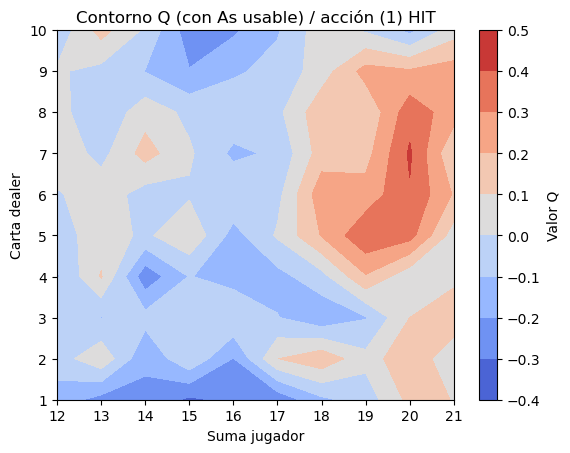

In [96]:
thorp_q_value = first_visit_mc_q_prediction_ie(thorp_policy, env_wrapped, number_episodes=50_000)

plot_Q_distribution(thorp_q_value)


<div style=" border-left: 6px solid #28a745; padding: 10px; border-radius: 5px;">

### Implementar el algoritmo un algoritmo de control Monte Carlo para estimar la politica óptima.
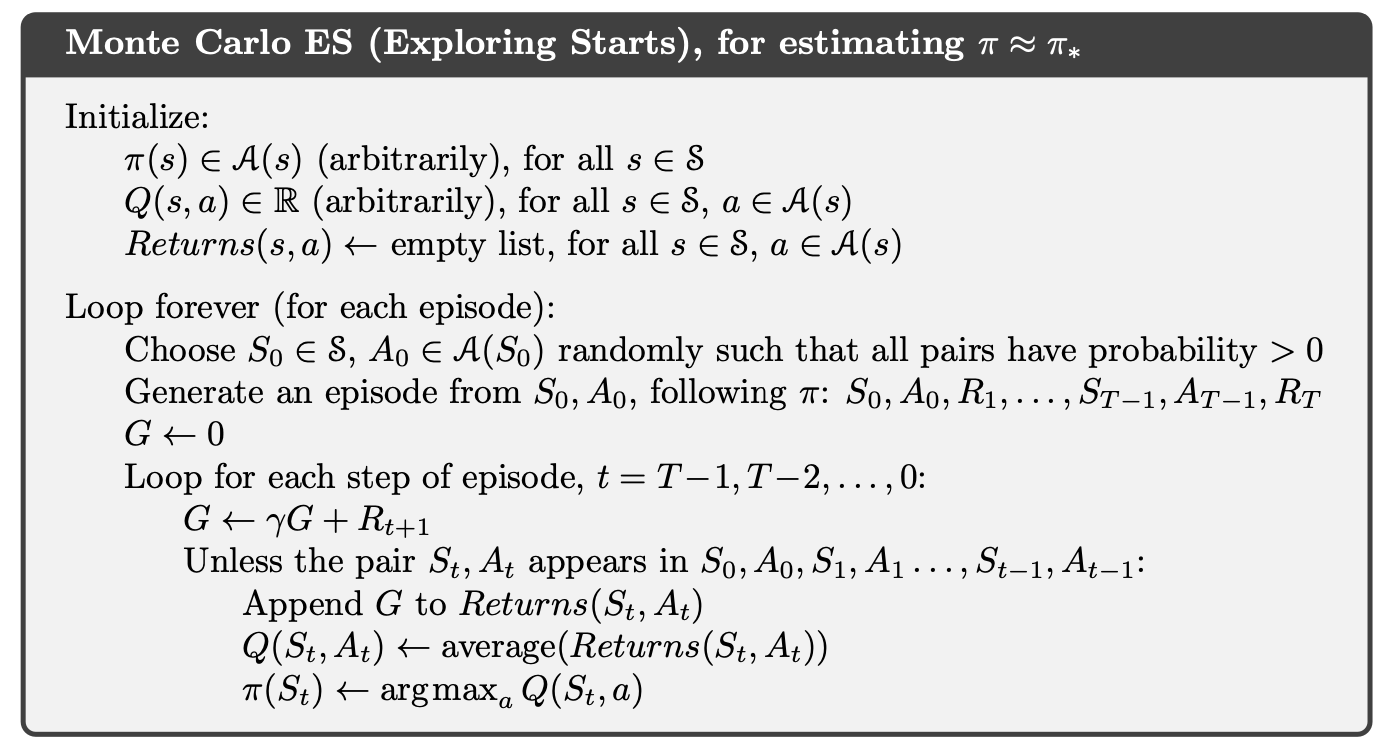
 

</div>

In [97]:
def generate_episode_with_random_action(policy, env):
    """
    Genera un episodio utilizando la política dada, con exploración inicial.
    """
    episode = []
    env.reset()
    
    # Escogemos un estado inicial aleatorio
    player_sum = np.random.randint(4, 22)   # suma entre 4 y 21
    dealer_card = np.random.randint(1, 11)     # carta del dealer entre 1 y 10
    usable = np.random.randint(0, 2)           # 0 o 1
    # Elejimos stado al azar 
    state = (player_sum, dealer_card, usable)
    
    # Usamos el método del wrapper para fijar el estado
    env.set_state(state)
    state = env._get_obs()

    done = False
    first_action = True
    while not done:
         # primera accion al azar
        if first_action:
            action = env.action_space.sample()
            first_action = False
         # proximas acciones basadas en la politica
        else:
            action = policy[state]
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode


In [98]:
# Monte Carlo Exploration Start
def mc_es(env, number_episodes, gamma=1.0):
    """
    Monte Carlo Exploring Starts (ES) para estimar la política óptima.

    Args:
        policy
        env: wrapped entorno (debe tener métodos reset(), step() y set_state())
        number_episodes: cantidad de episodios a correr
        gamma: factor de descuento

    Returns:
        policy: la política óptima encontrada
        Q: función de acción-valor estimada
    """
    # Inicializar arbitrariamente
    Q = defaultdict(float)
    Returns = defaultdict(list)
    policy = defaultdict(lambda: np.random.choice(np.arange(env.action_space.n)))

    for _ in range(number_episodes):
        # Elegir S0 y A0 al azar (exploring starts)
        episode = generate_episode_with_random_action(policy, env)
        
        # Procesar el episodio hacia atrás
        G = 0
        visited_state_action_pairs = set()

        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if (state, action) not in visited_state_action_pairs:
                Returns[(state, action)].append(G)
                Q[(state, action)] = np.mean(Returns[(state, action)])
                q_values = [Q[(state, a)] for a in range(env.action_space.n)]
                policy[state] = np.argmax(q_values)
                visited_state_action_pairs.add((state, action))

    return policy, Q
    

In [99]:
best_policy, mc_control = mc_es(env_wrapped, number_episodes=500_000)


In [100]:
print(best_policy)

defaultdict(<function mc_es.<locals>.<lambda> at 0x13c58e160>, {(12, 2, 1): np.int64(1), (4, 7, 0): np.int64(1), (17, 6, 1): np.int64(1), (14, 6, 0): np.int64(0), (14, 6, 1): np.int64(1), (12, 8, 1): np.int64(1), (19, 10, 0): np.int64(0), (13, 8, 0): np.int64(1), (20, 6, 1): np.int64(0), (12, 10, 1): np.int64(1), (13, 8, 1): np.int64(1), (21, 8, 1): np.int64(0), (21, 8, 0): np.int64(0), (20, 7, 0): np.int64(0), (15, 1, 0): np.int64(1), (14, 1, 0): np.int64(1), (12, 6, 0): np.int64(1), (16, 3, 1): np.int64(1), (11, 3, 0): np.int64(1), (10, 10, 0): np.int64(1), (20, 4, 0): np.int64(0), (13, 4, 0): np.int64(1), (19, 1, 0): np.int64(0), (18, 6, 0): np.int64(0), (13, 5, 0): np.int64(0), (20, 5, 0): np.int64(0), (17, 5, 1): np.int64(1), (12, 9, 1): np.int64(1), (14, 9, 0): np.int64(1), (18, 5, 1): np.int64(0), (18, 4, 1): np.int64(0), (12, 4, 1): np.int64(1), (20, 3, 0): np.int64(0), (8, 10, 0): np.int64(1), (13, 10, 0): np.int64(1), (21, 10, 0): np.int64(0), (4, 10, 0): np.int64(1), (12, 3,

In [101]:
print(best_policy[(19, 6, 0)])

0


0.889763779527559


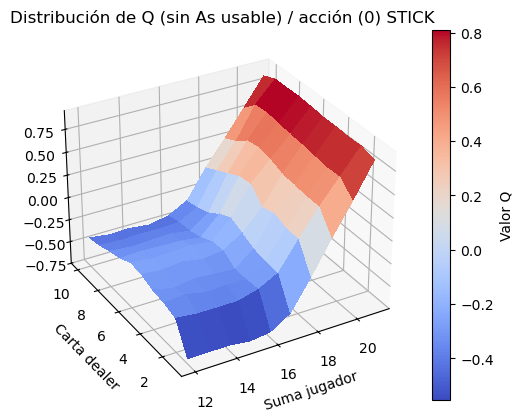

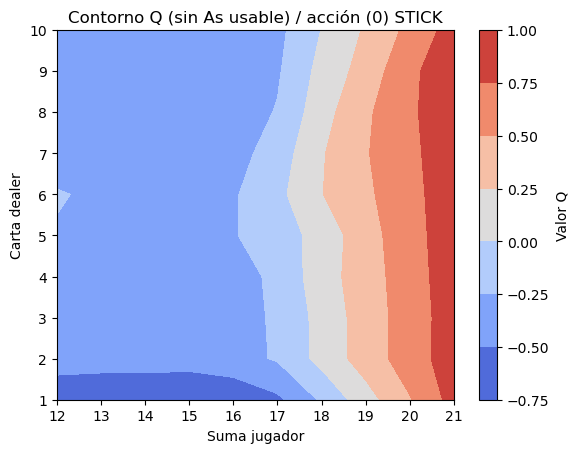

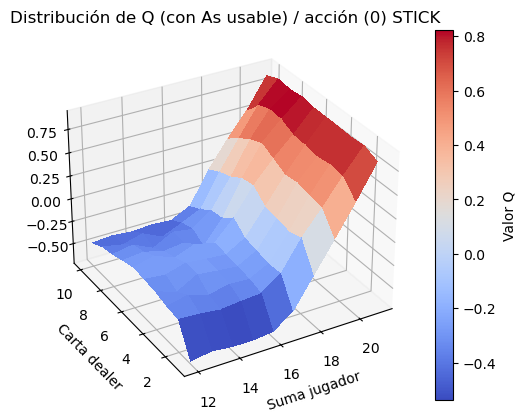

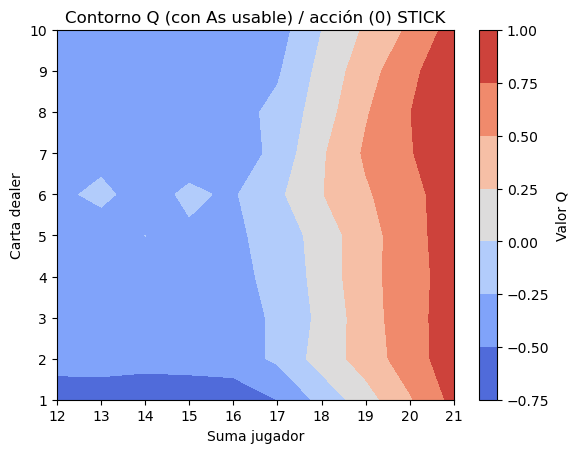

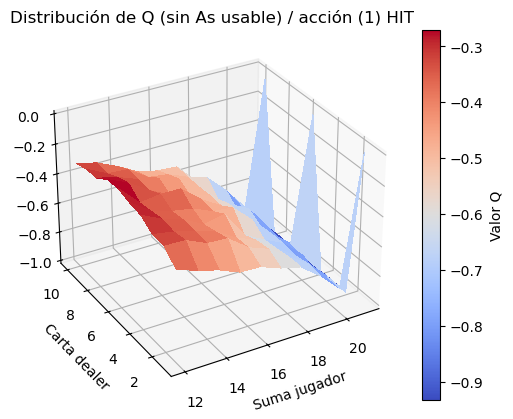

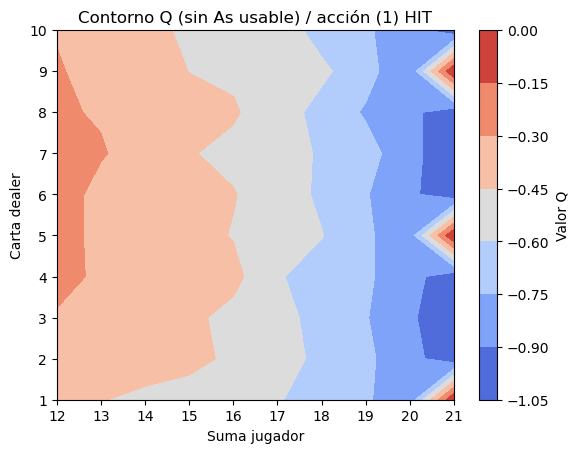

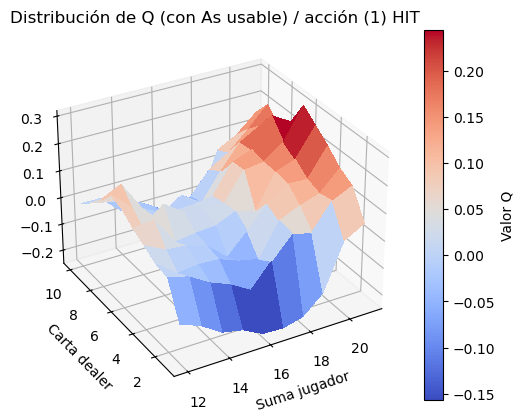

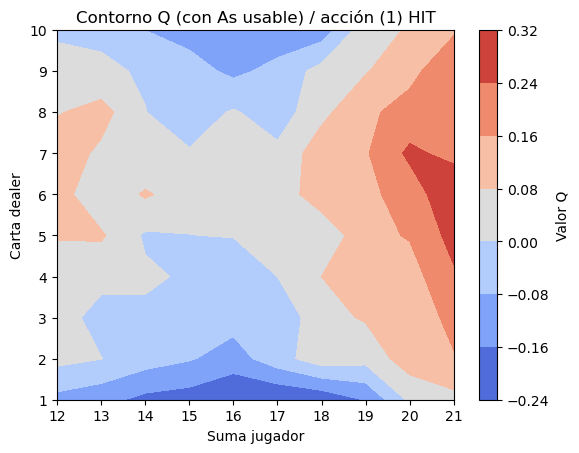

In [102]:
print(mc_control[(21, 5, 0), 0])
plot_Q_distribution(mc_control)

<div style=" border-left: 6px solid #28a745; padding: 10px; border-radius: 5px;">

### Comparamos Monte Carlo ES:
Comparando MC ES con las políticas anteriores se ve una diferencia clara en varios aspectos. Las políticas iniciales basadas en First-Visit MC Prediction dependen totalmente de la estrategia dada: si la política es limitada o mala, el aprendizaje también lo será. Además, esas políticas no exploran todas las acciones posibles, sino que solo siguen lo que la politica, sin mejorar a lo largo del tiempo. En cambio, MC ES fuerza la exploración desde el inicio, lo que le permite visitar todos los estados y acciones posibles y, a partir de eso, ir ajustando la política continuamente.

Mientras que con políticas fijas no necesariamente aprendemos la mejor jugada en cada situación, MC ES sí busca sistemáticamente la acción que ofrece el mejor retorno en cada estado. Tampoco depende de tener una política inicial buena, porque parte de explorar de manera aleatoria y desde ahí construye su conocimiento. En definitiva, con políticas fijas obtenemos buenas estimaciones solo si las mismas tiene una buena estrategia, pero MC ES puede aprender una política óptima o muy cercana a la óptima independientemente de dónde empiece.

De los graficos podemos deducir que la politica generada por MC ES es claramente mejor que cualquier política inicial fija. Los valores de Q reflejan decisiones más inteligentes. Además, podemos ver que en la distribución de Q las expectativas de recompensa son mejores que jugando con políticas simples como "me planto en 20".

En conclusión: MC ES supera a las políticas fijas anteriores. Aunque no elimina la ventaja de la casa —porque las reglas del blackjack siguen favoreciendo al casino— sí maximiza las chances del jugador de ganar o, al menos, de minimizar sus pérdidas. Gracias a MC ES, el jugador juega de la mejor forma posible en cada situación.

</div>

## **Tareas**

1. Implementar el algoritmo de Monte Carlo First Visit para estimar la función de valor $V$ y $Q$ para la política definida.
2. Comparar las estimaciones de la función de valor para distintos episodios (ej: 100, 10000, 50000, 500000). 
3. Elaborar una política diferente que tenga en cuenta el As usable y estimar su función de valor.
4. [extra] Implementar el algoritmo un algoritmo de control Monte Carlo para estimar la politica óptima. Puede ser MC ES para control (cap 5.3 del libro) o on-policy MC control (cap 5.4 del libro). Graficar resultados y comparar con politicas anteriores. ¿ Puede asegurar que "la casa siempre gana" ? 🎰